In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r /content/drive/MyDrive/Solor_Panels_Segmentation/model_development_dataset /content/pvdata
print("✅ copied to /content/pvdata")

✅ copied to /content/pvdata


In [ ]:
# ==========================
# 数据与结果路径设置（根据你现在的结构）
# ==========================
import os

# 你的数据已经在 /content/pvdata 下面了
DATA_ROOT = '/content/pvdata'
RESULT_DIR = '/content/drive/MyDrive/results_mask2former'  # 可以改到你想保存的位置

os.makedirs(RESULT_DIR, exist_ok=True)

print("✅ 数据路径:", DATA_ROOT)
print("📂 目录结构示例：")
print(os.listdir(DATA_ROOT))


✅ 数据路径: /content/pvdata
📂 目录结构示例：
['train', 'train.txt', 'val.txt', 'val']


In [ ]:
# ==========================
# 数据集定义：读取 PNG 图像和二值 mask
# 适配当前结构：
# /content/pvdata/train/img, /content/pvdata/train/mask
# /content/pvdata/val/img,   /content/pvdata/val/mask
# ==========================
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import os

class SolarSegDataset(Dataset):
    """
    txt 文件每行是一个样本 id，例如:
    XKKNW4DDEBSDD
    11YJ4L7H4K2M9C
    ...
    对应图片:
      train: /content/pvdata/train/img/{id}.png
             /content/pvdata/train/mask/{id}.png
      val:   /content/pvdata/val/img/{id}.png
             /content/pvdata/val/mask/{id}.png
    """
    def __init__(self, txt_path, root_dir, phase='train', img_size=(400, 400)):
        assert phase in ['train', 'val']
        self.root_dir = root_dir
        self.phase = phase
        self.img_size = img_size

        # 读取 id 列表
        with open(txt_path, 'r') as f:
            self.ids = [line.strip() for line in f.readlines() if line.strip()]

        # 根据 phase 决定子目录
        self.img_dir = os.path.join(root_dir, phase, 'img')
        self.mask_dir = os.path.join(root_dir, phase, 'mask')

        print(f"✅ {phase} samples: {len(self.ids)}")
        print(f"   img_dir:  {self.img_dir}")
        print(f"   mask_dir: {self.mask_dir}")

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        id_ = self.ids[idx]
        img_path = os.path.join(self.img_dir, id_ + '.png')
        mask_path = os.path.join(self.mask_dir, id_ + '.png')

        # debug 时可以打开
        # print(img_path, mask_path)

        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)

        # 统一 resize 到 400x400
        img = img.resize(self.img_size, resample=Image.BILINEAR)
        mask = mask.resize(self.img_size, resample=Image.NEAREST)

        # mask 转为 {0,1}，PV 像素 >0 视为 1
        mask_np = (np.array(mask) > 0).astype(np.int64)

        return {"image": img, "mask": mask_np}


# ===== 实例化 Dataset =====
TRAIN_TXT = os.path.join(DATA_ROOT, 'train.txt')
VAL_TXT   = os.path.join(DATA_ROOT, 'val.txt')

train_dataset = SolarSegDataset(TRAIN_TXT, DATA_ROOT, 'train',img_size=(240, 240))
val_dataset   = SolarSegDataset(VAL_TXT, DATA_ROOT, 'val',img_size=(240, 240))

print(f"✅ train: {len(train_dataset)}, val: {len(val_dataset)}")


✅ train samples: 6415
   img_dir:  /content/pvdata/train/img
   mask_dir: /content/pvdata/train/mask
✅ val samples: 1604
   img_dir:  /content/pvdata/val/img
   mask_dir: /content/pvdata/val/mask
✅ train: 6415, val: 1604


In [ ]:
# ==========================
# Mask2Former 模型与 DataLoader
# ==========================
import torch
from transformers import Mask2FormerImageProcessor, Mask2FormerForUniversalSegmentation

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("✅ 使用设备:", device)
if device == 'cuda':
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True

# 使用在 ADE20K 上语义分割预训练的 Mask2Former
checkpoint = "facebook/mask2former-swin-base-IN21k-ade-semantic"

# 图像处理器：负责 resize / normalize / 生成 mask_labels 和 class_labels
processor = Mask2FormerImageProcessor.from_pretrained(
    checkpoint,
    do_reduce_labels=False  # 我们自己已经是 0/1，不需要 shift label
)

# 模型：指定 num_labels=2（二分类），ignore_mismatched_sizes=True 让 head 自动适配
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    checkpoint,
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

# 统计参数数量（Model Parameters）
total_params = sum(p.numel() for p in model.parameters()) / 1e6
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
print(f"📊 Model Parameters: total = {total_params:.2f} M, trainable = {trainable_params:.2f} M")

from torch.utils.data import DataLoader

def collate_fn(examples):
    """
    examples: list of {"image": PIL, "mask": np.ndarray(H,W)}
    使用 Mask2FormerImageProcessor 将其打包成 batch：
      - pixel_values: (B,3,H,W)
      - pixel_mask: (B,H,W)
      - mask_labels: list[Tensor( num_masks, H, W )]
      - class_labels: list[Tensor( num_masks )]
    这里我们的语义分割其实只有一个前景类，但 ImageProcessor 会自动把 0/1 mask
    转成若干二值 mask + 对应的 class label。
    """
    images = [e["image"] for e in examples]
    masks  = [e["mask"]  for e in examples]

    # 用 image processor 构造输入
    encoded_inputs = processor(
        images,
        segmentation_maps=masks,
        return_tensors="pt"
    )

    # 同时把原始 mask 也打包进去，用于计算 mIoU / F1 等验证指标
    encoded_inputs["original_masks"] = torch.stack(
        [torch.from_numpy(m.astype(np.int64)) for m in masks],
        dim=0
    )

    return encoded_inputs

BATCH_SIZE = 2  # Mask2Former 比较大，batch 不要太大
NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn
)

print("✅ DataLoader 已创建")


✅ 使用设备: cuda
GPU: Tesla T4


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/432M [00:00<?, ?B/s]

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: total = 106.88 M, trainable = 106.88 M


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ DataLoader 已创建


model.safetensors:   0%|          | 0.00/432M [00:00<?, ?B/s]

In [ ]:
# ==========================
# Mask2Former 模型（可选自动/手动 batch_size）
# ==========================
import torch
from torch.utils.data import DataLoader
from transformers import Mask2FormerImageProcessor, Mask2FormerForUniversalSegmentation

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("✅ 使用设备:", device, torch.cuda.get_device_name(0) if device == 'cuda' else '')
if device == 'cuda':
    torch.backends.cudnn.benchmark = True

checkpoint = "facebook/mask2former-swin-base-IN21k-ade-semantic"

processor = Mask2FormerImageProcessor.from_pretrained(
    checkpoint,
    do_reduce_labels=False
)

model = Mask2FormerForUniversalSegmentation.from_pretrained(
    checkpoint,
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

total_params = sum(p.numel() for p in model.parameters()) / 1e6
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
print(f"📊 Model Parameters: total = {total_params:.2f} M, trainable = {trainable_params:.2f} M")

# collate_fn 和之前一样
def collate_fn(examples):
    images = [e["image"] for e in examples]
    masks  = [e["mask"]  for e in examples]

    encoded_inputs = processor(
        images,
        segmentation_maps=masks,
        return_tensors="pt"
    )

    encoded_inputs["original_masks"] = torch.stack(
        [torch.from_numpy(m.astype('int64')) for m in masks],
        dim=0
    )

    return encoded_inputs

# ==========================
# 🔧 这里选择是否自动找 batch_size
# ==========================
USE_AUTO_BS = False   # 👈 想强制用 8，就把它设成 False

def find_max_batch(model, dataset, device='cuda', start_bs=4):
    bs = start_bs
    while bs >= 1:
        try:
            print(f"\n🔍 尝试 batch_size = {bs} ...")
            loader = DataLoader(
                dataset,
                batch_size=bs,
                shuffle=False,
                num_workers=2,
                pin_memory=True,
                collate_fn=collate_fn
            )
            batch = next(iter(loader))
            pixel_values = batch["pixel_values"].to(device)
            pixel_mask   = batch.get("pixel_mask")
            if pixel_mask is not None:
                pixel_mask = pixel_mask.to(device)

            if device == 'cuda':
                with torch.cuda.amp.autocast(enabled=True):
                    _ = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
                torch.cuda.synchronize()
            else:
                _ = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

            if device == 'cuda':
                torch.cuda.empty_cache()

            print(f"✅ batch_size={bs} OK")
            return bs

        except RuntimeError as e:
            msg = str(e).lower()
            if "out of memory" in msg or "cuda out of memory" in msg:
                print(f"⚠️ batch_size={bs} OOM，尝试更小的 ...")
                if device == 'cuda':
                    torch.cuda.empty_cache()
                bs //= 2
            else:
                raise e
    print("⚠️ 所有尝试都失败，回退到 batch_size = 1")
    return 1

if USE_AUTO_BS:
    best_bs = find_max_batch(model, train_dataset, device=device, start_bs=8)
else:
    best_bs = 8   # 👈👈👈 强行使用 batch_size = 8 就改这里

print("👉 最终使用 batch_size:", best_bs)

# ==========================
# DataLoader
# ==========================
train_loader = DataLoader(
    train_dataset,
    batch_size=best_bs,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=best_bs,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn,
    persistent_workers=True
)

first_batch = next(iter(train_loader))
print("🧪 检查 train_loader：pixel_values shape =", first_batch["pixel_values"].shape)
print("   len(train_loader) =", len(train_loader))
print("✅ Mask2Former + batch_size 配置完成")


✅ 使用设备: cuda Tesla T4


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: total = 106.88 M, trainable = 106.88 M
👉 最终使用 batch_size: 8
🧪 检查 train_loader：pixel_values shape = torch.Size([8, 3, 384, 384])
   len(train_loader) = 802
✅ Mask2Former + batch_size 配置完成


In [ ]:
# ==========================
# 度量函数：mIoU / Precision / Recall / F1
# ==========================
import numpy as np

def update_confusion_matrix(conf_mat, preds, gts, num_classes=2):
    """
    conf_mat: (num_classes, num_classes)
    preds, gts: 2D numpy 数组，取值为 [0, num_classes-1]
    conf_mat[gt, pred] += 1
    """
    assert preds.shape == gts.shape
    preds = preds.reshape(-1)
    gts   = gts.reshape(-1)

    for c_gt in range(num_classes):
        for c_pred in range(num_classes):
            conf_mat[c_gt, c_pred] += np.sum((gts == c_gt) & (preds == c_pred))

    return conf_mat

def compute_metrics_from_confusion(conf_mat):
    """
    二分类情况下：
    conf_mat:
       gt\pred   0       1
          0    tn      fp
          1    fn      tp
    """
    num_classes = conf_mat.shape[0]

    # mIoU
    ious = []
    for c in range(num_classes):
        tp_c = conf_mat[c, c]
        fp_c = conf_mat[:, c].sum() - tp_c
        fn_c = conf_mat[c, :].sum() - tp_c
        denom = tp_c + fp_c + fn_c
        if denom == 0:
            ious.append(1.0)
        else:
            ious.append(tp_c / (denom + 1e-8))
    mIoU = float(np.mean(ious))

    # 对前景类 (class=1) 计算 Precision / Recall / F1
    tn = conf_mat[0, 0]
    fp = conf_mat[0, 1]
    fn = conf_mat[1, 0]
    tp = conf_mat[1, 1]

    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)

    return mIoU, precision, recall, f1


<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-2863469730.py:26: SyntaxWarning: invalid escape sequence '\p'
  gt\pred   0       1


In [ ]:
# ==========================
# 手动清理 GPU 显存 / 变量
# ==========================
import torch, gc

# 1. 删掉旧模型 / 优化器 / scaler（有的话）
try:
    del model
except:
    pass

try:
    del optimizer
except:
    pass

try:
    del scaler
except:
    pass

# 如果你想一并删掉 DataLoader 也可以（可选）
try:
    del train_loader
    del val_loader
except:
    pass

# 2. Python 垃圾回收 + CUDA 缓存清理
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

print("✅ 已尝试清理 GPU 显存")
print("当前显存占用(allocated):", torch.cuda.memory_allocated() / 1024**2, "MB")
print("当前显存保留(reserved):", torch.cuda.memory_reserved() / 1024**2, "MB")


✅ 已尝试清理 GPU 显存
当前显存占用(allocated): 479.677734375 MB
当前显存保留(reserved): 1320.0 MB


In [ ]:
# ==========================
# Mask2Former 训练循环 + Early Stopping
# ==========================
import torch
import numpy as np
from tqdm.auto import tqdm
from torch.cuda.amp import GradScaler, autocast

EPOCHS = 80            # 理论最大 epoch 数
PATIENCE = 8           # mIoU 连续 PATIENCE 轮不提升就 early stop
lr = 5e-5
weight_decay = 1e-4

# 只优化 requires_grad=True 的参数（如果你有冻结 backbone）
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=lr,
    weight_decay=weight_decay
)
scaler = GradScaler(enabled=(device == 'cuda'))

history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_mIoU": [],
    "val_precision": [],
    "val_recall": [],
    "val_f1": []
}

best_mIoU = 0.0
best_ckpt_path = None
no_improve_epochs = 0   # 用来计数连续几轮没提升

for epoch in range(1, EPOCHS + 1):
    print(f"\n================ Epoch {epoch}/{EPOCHS} ================")

    # ---------- Train ----------
    model.train()
    train_losses = []

    pbar = tqdm(train_loader, desc="Train", leave=False)
    for batch in pbar:
        pixel_values = batch["pixel_values"].to(device)
        pixel_mask   = batch.get("pixel_mask")
        if pixel_mask is not None:
            pixel_mask = pixel_mask.to(device)

        mask_labels  = [m.to(device) for m in batch["mask_labels"]]
        class_labels = [c.to(device) for c in batch["class_labels"]]

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=(device == 'cuda')):
            outputs = model(
                pixel_values=pixel_values,
                pixel_mask=pixel_mask,
                mask_labels=mask_labels,
                class_labels=class_labels
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_losses.append(loss.item())
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_train_loss = float(np.mean(train_losses))

    # ---------- Validation ----------
    model.eval()
    val_losses = []
    conf_mat = np.zeros((2, 2), dtype=np.float64)

    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Val", leave=False)
        for batch in pbar:
            pixel_values = batch["pixel_values"].to(device)
            pixel_mask   = batch.get("pixel_mask")
            if pixel_mask is not None:
                pixel_mask = pixel_mask.to(device)

            mask_labels  = [m.to(device) for m in batch["mask_labels"]]
            class_labels = [c.to(device) for c in batch["class_labels"]]
            gt_masks     = batch["original_masks"]  # (B,H,W) on CPU

            with autocast(enabled=(device == 'cuda')):
                outputs = model(
                    pixel_values=pixel_values,
                    pixel_mask=pixel_mask,
                    mask_labels=mask_labels,
                    class_labels=class_labels
                )
                loss = outputs.loss

            val_losses.append(loss.item())

            target_sizes = [(m.shape[-2], m.shape[-1]) for m in gt_masks]
            semseg = processor.post_process_semantic_segmentation(
                outputs, target_sizes=target_sizes
            )

            for pred_map, gt in zip(semseg, gt_masks):
                pred_np = pred_map.cpu().numpy().astype(np.int64)
                gt_np   = gt.numpy().astype(np.int64)
                conf_mat = update_confusion_matrix(conf_mat, pred_np, gt_np, num_classes=2)

    avg_val_loss = float(np.mean(val_losses))
    mIoU, precision, recall, f1 = compute_metrics_from_confusion(conf_mat)

    history["epoch"].append(epoch)
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["val_mIoU"].append(mIoU)
    history["val_precision"].append(precision)
    history["val_recall"].append(recall)
    history["val_f1"].append(f1)

    print(f"Epoch {epoch}: "
          f"Train Loss={avg_train_loss:.4f} | "
          f"Val Loss={avg_val_loss:.4f} | "
          f"mIoU={mIoU:.4f} | "
          f"P={precision:.4f} | R={recall:.4f} | F1={f1:.4f}")

    # ---------- 保存最佳模型 ----------
    if mIoU > best_mIoU + 1e-4:  # 有明显提升
        best_mIoU = mIoU
        no_improve_epochs = 0

        best_ckpt_path = os.path.join(
            RESULT_DIR,
            f"mask2former_best_epoch{epoch}_miou{mIoU:.4f}.pth"
        )
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, best_ckpt_path)
        print(f"💾 保存新最佳模型到: {best_ckpt_path}")
    else:
        no_improve_epochs += 1
        print(f"📉 mIoU 未提升，连续无提升轮数: {no_improve_epochs}/{PATIENCE}")

    # ---------- Early Stopping 判断 ----------
    if no_improve_epochs >= PATIENCE:
        print(f"\n⛔ 触发 Early Stopping：连续 {PATIENCE} 个 epoch mIoU 没有提升，提前结束训练。")
        break

print("\n⭐ 训练结束")
print(f"最佳 mIoU = {best_mIoU:.4f}, checkpoint = {best_ckpt_path}")



================ Epoch 1/80 ================


/tmp/ipython-input-3348883938.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device == 'cuda'))


Train:   0%|          | 0/802 [00:00<?, ?it/s]

/tmp/ipython-input-3348883938.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == 'cuda')):


Val:   0%|          | 0/201 [00:00<?, ?it/s]

/tmp/ipython-input-3348883938.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == 'cuda')):


Epoch 1: Train Loss=4.9967 | Val Loss=3.1902 | mIoU=0.9527 | P=0.9504 | R=0.9519 | F1=0.9511
💾 保存新最佳模型到: /content/drive/MyDrive/results_mask2former/mask2former_best_epoch1_miou0.9527.pth

================ Epoch 2/80 ================


Train:   0%|          | 0/802 [00:00<?, ?it/s]

Val:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2: Train Loss=2.9115 | Val Loss=2.8368 | mIoU=0.9566 | P=0.9515 | R=0.9591 | F1=0.9553
💾 保存新最佳模型到: /content/drive/MyDrive/results_mask2former/mask2former_best_epoch2_miou0.9566.pth

================ Epoch 3/80 ================


Train:   0%|          | 0/802 [00:00<?, ?it/s]

Val:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3: Train Loss=2.5728 | Val Loss=2.6461 | mIoU=0.9592 | P=0.9600 | R=0.9564 | F1=0.9582
💾 保存新最佳模型到: /content/drive/MyDrive/results_mask2former/mask2former_best_epoch3_miou0.9592.pth

================ Epoch 4/80 ================


Train:   0%|          | 0/802 [00:00<?, ?it/s]

Val:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 4: Train Loss=2.4854 | Val Loss=2.7892 | mIoU=0.9568 | P=0.9606 | R=0.9506 | F1=0.9556
📉 mIoU 未提升，连续无提升轮数: 1/8

================ Epoch 5/80 ================


Train:   0%|          | 0/802 [00:00<?, ?it/s]

Val:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 5: Train Loss=2.4903 | Val Loss=2.6874 | mIoU=0.9579 | P=0.9640 | R=0.9496 | F1=0.9568
📉 mIoU 未提升，连续无提升轮数: 2/8

================ Epoch 6/80 ================


Train:   0%|          | 0/802 [00:00<?, ?it/s]

Val:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 6: Train Loss=2.2784 | Val Loss=2.6147 | mIoU=0.9598 | P=0.9660 | R=0.9517 | F1=0.9588
💾 保存新最佳模型到: /content/drive/MyDrive/results_mask2former/mask2former_best_epoch6_miou0.9598.pth

================ Epoch 7/80 ================


Train:   0%|          | 0/802 [00:00<?, ?it/s]

Val:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 7: Train Loss=2.2140 | Val Loss=2.5999 | mIoU=0.9605 | P=0.9570 | R=0.9620 | F1=0.9595
💾 保存新最佳模型到: /content/drive/MyDrive/results_mask2former/mask2former_best_epoch7_miou0.9605.pth

================ Epoch 8/80 ================


Train:   0%|          | 0/802 [00:00<?, ?it/s]

Val:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 8: Train Loss=2.1554 | Val Loss=2.6687 | mIoU=0.9591 | P=0.9612 | R=0.9548 | F1=0.9580
📉 mIoU 未提升，连续无提升轮数: 1/8

================ Epoch 9/80 ================


Train:   0%|          | 0/802 [00:00<?, ?it/s]

Val:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 9: Train Loss=2.2885 | Val Loss=3.0445 | mIoU=0.9480 | P=0.9333 | R=0.9590 | F1=0.9460
📉 mIoU 未提升，连续无提升轮数: 2/8

================ Epoch 10/80 ================


Train:   0%|          | 0/802 [00:00<?, ?it/s]

Val:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 10: Train Loss=2.3311 | Val Loss=2.6698 | mIoU=0.9585 | P=0.9609 | R=0.9540 | F1=0.9574
📉 mIoU 未提升，连续无提升轮数: 3/8

================ Epoch 11/80 ================


Train:   0%|          | 0/802 [00:00<?, ?it/s]

Val:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 11: Train Loss=2.1205 | Val Loss=2.6023 | mIoU=0.9600 | P=0.9622 | R=0.9559 | F1=0.9590
📉 mIoU 未提升，连续无提升轮数: 4/8

================ Epoch 12/80 ================


Train:   0%|          | 0/802 [00:00<?, ?it/s]

Val:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 12: Train Loss=2.0240 | Val Loss=2.5907 | mIoU=0.9602 | P=0.9659 | R=0.9525 | F1=0.9592
📉 mIoU 未提升，连续无提升轮数: 5/8

================ Epoch 13/80 ================


Train:   0%|          | 0/802 [00:00<?, ?it/s]

Val:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 13: Train Loss=1.9959 | Val Loss=2.6921 | mIoU=0.9580 | P=0.9565 | R=0.9571 | F1=0.9568
📉 mIoU 未提升，连续无提升轮数: 6/8

================ Epoch 14/80 ================


Train:   0%|          | 0/802 [00:00<?, ?it/s]

Val:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 14: Train Loss=2.4175 | Val Loss=2.6615 | mIoU=0.9582 | P=0.9552 | R=0.9590 | F1=0.9571
📉 mIoU 未提升，连续无提升轮数: 7/8

================ Epoch 15/80 ================


Train:   0%|          | 0/802 [00:00<?, ?it/s]

Val:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 15: Train Loss=2.0661 | Val Loss=2.6346 | mIoU=0.9605 | P=0.9597 | R=0.9593 | F1=0.9595
📉 mIoU 未提升，连续无提升轮数: 8/8

⛔ 触发 Early Stopping：连续 8 个 epoch mIoU 没有提升，提前结束训练。

⭐ 训练结束
最佳 mIoU = 0.9605, checkpoint = /content/drive/MyDrive/results_mask2former/mask2former_best_epoch7_miou0.9605.pth


In [ ]:
total_params = sum(p.numel() for p in model.parameters()) / 1e6
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
print(f"📊 Model Parameters: total = {total_params:.2f} M, trainable = {trainable_params:.2f} M")


📊 Model Parameters: total = 106.88 M, trainable = 106.88 M


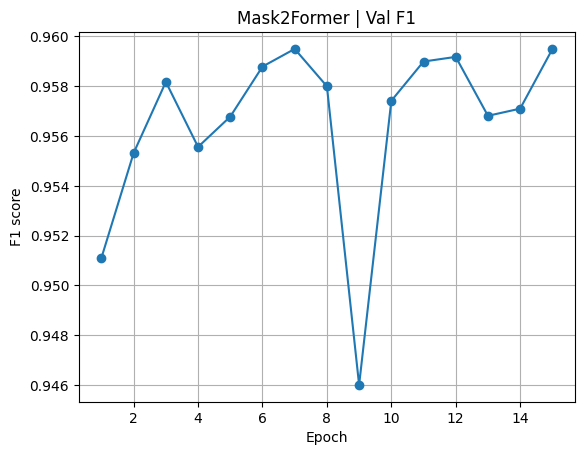

✅ Saved: /content/drive/MyDrive/results_mask2former/mask2former_val_f1.png


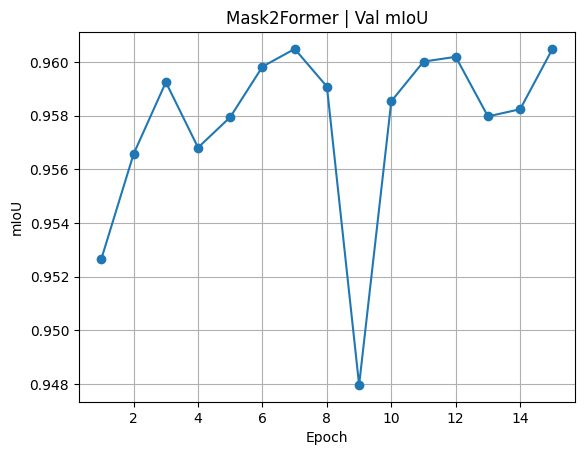

✅ Saved: /content/drive/MyDrive/results_mask2former/mask2former_val_miou.png


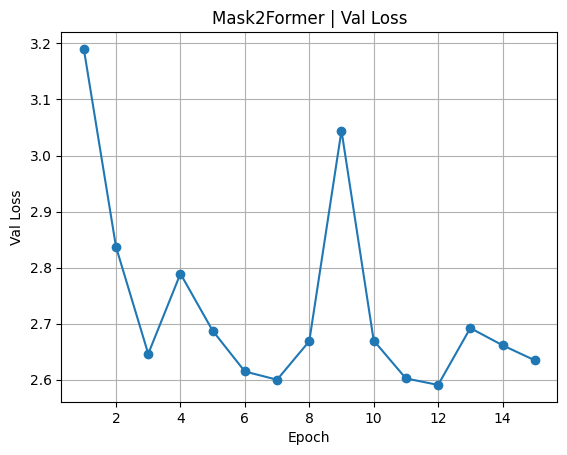

✅ Saved: /content/drive/MyDrive/results_mask2former/mask2former_val_loss.png


In [ ]:
# ==========================
# 可视化：Epoch vs F1 / mIoU / Val Loss
# ==========================
import matplotlib.pyplot as plt

epochs = history["epoch"]

def plot_curve(x, y, ylabel, title, save_name):
    plt.figure()
    plt.plot(x, y, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    path = os.path.join(RESULT_DIR, save_name)
    plt.savefig(path, dpi=160)
    plt.show()
    print("✅ Saved:", path)

# Epoch vs F1
plot_curve(epochs, history["val_f1"], "F1 score", "Mask2Former | Val F1", "mask2former_val_f1.png")

# Epoch vs mIoU
plot_curve(epochs, history["val_mIoU"], "mIoU", "Mask2Former | Val mIoU", "mask2former_val_miou.png")

# Epoch vs Val Loss
plot_curve(epochs, history["val_loss"], "Val Loss", "Mask2Former | Val Loss", "mask2former_val_loss.png")


In [ ]:
# ==========================
# Computer configuration
# ==========================
!nvidia-smi
!cat /etc/os-release
!lscpu | grep "Model name"
!free -h

import torch
print("PyTorch version:", torch.__version__)


Fri Nov 14 05:25:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             28W /   70W |   11716MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# ==========================
# Inference time (ms / image)
# ==========================
import time
from torch.cuda.amp import autocast
from tqdm.auto import tqdm

model.eval()

num_images = 0
total_time = 0.0

with torch.no_grad():
    pbar = tqdm(val_loader, desc="Measure Inference Time", leave=False)
    for batch in pbar:
        pixel_values = batch["pixel_values"].to(device)
        pixel_mask   = batch.get("pixel_mask")
        if pixel_mask is not None:
            pixel_mask = pixel_mask.to(device)

        bs = pixel_values.shape[0]

        # 先同步一次，保证计时干净
        if device == 'cuda':
            torch.cuda.synchronize()
        start = time.perf_counter()

        # ❗ 这里不要再写 device_type，保持和训练循环一致
        with autocast(enabled=(device == 'cuda')):
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        if device == 'cuda':
            torch.cuda.synchronize()
        end = time.perf_counter()

        total_time += (end - start)
        num_images += bs

ms_per_image = total_time / num_images * 1000.0
fps = num_images / total_time

print(f"⚡ Average inference time: {ms_per_image:.2f} ms / image")
print(f"⚡ Throughput: {fps:.2f} images / second")


Measure Inference Time:   0%|          | 0/201 [00:00<?, ?it/s]

/tmp/ipython-input-3243077970.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == 'cuda')):


⚡ Average inference time: 43.20 ms / image
⚡ Throughput: 23.15 images / second
